In [1]:
import sys
sys.path.append("./libs/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy

C:\Users\victo\AppData\Local\Temp\ipykernel_23052\3313560318.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Carga de datos

In [3]:
df = pd.read_csv('./data/USA_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 1976-12-01 to 2022-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INDPRO     552 non-null    float64
 1   PAYEMS     552 non-null    float64
 2   UNRATENSA  552 non-null    float64
 3   MPRIME     552 non-null    float64
 4   TOTALSA    552 non-null    float64
 5   Class      552 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 30.2 KB


In [5]:
df.describe()

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
count,552.000000,552.000000,552.000000,552.000000,5.520000e+02,552.000000
mean,0.001504,0.001188,0.001758,-0.000092,-6.503275e-07,0.115942
std,0.003272,0.001763,0.017313,0.018738,8.059840e-03,0.320446
min,-0.012309,-0.006452,-0.096487,-0.051722,-3.474568e-02,0.000000
25%,0.000322,0.000509,-0.003765,-0.009446,-3.181993e-03,0.000000
50%,0.002075,0.001442,0.005265,0.000082,7.457537e-04,0.000000
75%,0.003471,0.002111,0.009246,0.013065,5.037476e-03,0.000000
max,0.008630,0.004349,0.054615,0.048879,1.919342e-02,1.000000


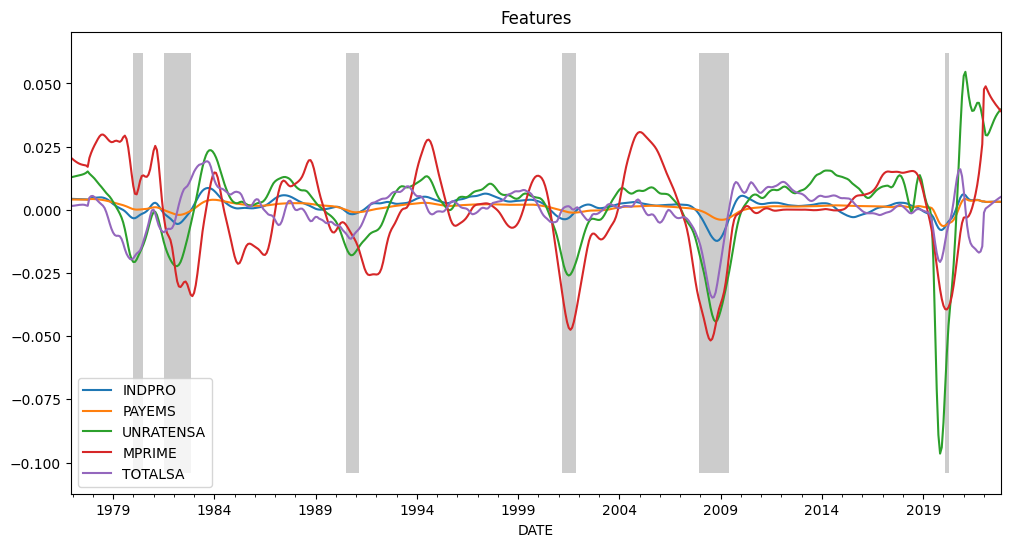

In [6]:
graficarTodo(df,'Features')

# Dividir Datos

In [7]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.2)

# Normalizar

In [8]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

In [9]:
n_features = len(features)

In [10]:
res_eeuu_1 = {
    'MLP_EEUU':['./modelamiento/modelos/MLP_USA_1_20240211_1447_2.h5', 24],
    'CNN_EEUU':['./modelamiento/modelos/CNN_USA_1_20240211_1730_7.h5', 19],
    'LSTM_EEUU':['./modelamiento/modelos/LSTM_USA_1_20240222_1417_5.h5', 7],
    'GRU_EEUU':['./modelamiento/modelos/GRU_USA_1_20240211_2020_4.h5', 10],
}
res_eeuu_6 = {
    'MLP_EEUU':['./modelamiento/modelos/MLP_USA_6_20240211_1447_2.h5', 7],
    'CNN_EEUU':['./modelamiento/modelos/CNN_USA_6_20240211_1730_0.h5', 14],
    'LSTM_EEUU':['./modelamiento/modelos/LSTM_USA_6_20240222_1417_0.h5', 5],
    'GRU_EEUU':['./modelamiento/modelos/GRU_USA_6_20240211_2020_11.h5', 6],
}
res_eeuu_12 = {
    'MLP_EEUU':['./modelamiento/modelos/MLP_USA_12_20240211_1447_9.h5', 24],
    'CNN_EEUU':['./modelamiento/modelos/CNN_USA_12_20240211_1730_5.h5', 22],
    'LSTM_EEUU':['./modelamiento/modelos/LSTM_USA_12_20240222_1417_8.h5', 9],
    'GRU_EEUU':['./modelamiento/modelos/GRU_USA_12_20240211_2020_2.h5', 8],
}

# Evaluar

In [11]:
def predecir(models: dict, n_steps_out):
    df_res = df_y_test.copy()
    df_res = df_res.shift(-n_steps_out)
    df_val = pd.DataFrame()

    for key in models.keys():
        n_steps_in = models[key][1]
        model = load_model(models[key][0])
        #x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
        x_test, y_test, indexes = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
        y_pred = model(x_test)
        df = pd.DataFrame()
        df['DATE'] = indexes
        df['DATE'] = pd.to_datetime(df['DATE'])
        df[key] = y_pred
        df = df.set_index('DATE')
        df_res = pd.concat([df_res, df[key]], axis=1)
    
        res = model.evaluate(x_test, y_test, verbose=0)
        df_val_n = pd.DataFrame({
            'tp': [res[1]],
            'fp': [res[2]],
            'tn': [res[3]],
            'fn': [res[4]],
            'accuracy': [res[5]],
            'precision': [res[6]],
            'recall': [res[7]],
            'auc': [res[8]],
            'prc': [res[9]],
        }, index = [key])
        df_val = pd.concat([df_val, df_val_n])

    return df_res, df_val

In [12]:
df_1, df_1_val = predecir(res_eeuu_1,1)
#graficarTodo(df_1,"Predicción de Recesión con 1 mes de anticipación")
df_1_val

g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_EEUU,3.0,11.0,72.0,0.0,0.872093,0.214286,1.0,0.969880,0.375000
CNN_EEUU,3.0,11.0,77.0,0.0,0.879121,0.214286,1.0,0.965909,0.333333
LSTM_EEUU,3.0,11.0,89.0,0.0,0.893204,0.214286,1.0,0.991667,0.776122
GRU_EEUU,3.0,11.0,86.0,0.0,0.890000,0.214286,1.0,0.984536,0.500000


In [13]:
df_6,df_6_val = predecir(res_eeuu_6,6)
#graficarTodo(df_6,"Predicción de Recesión con 6 meses de anticipación")
df_6_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_EEUU,3.0,7.0,88.0,0.0,0.928571,0.300000,1.000000,0.984211,0.500000
CNN_EEUU,3.0,40.0,48.0,0.0,0.560440,0.069767,1.000000,1.000000,1.000000
LSTM_EEUU,0.0,7.0,90.0,3.0,0.900000,0.000000,0.000000,0.902062,0.125968
GRU_EEUU,2.0,1.0,95.0,1.0,0.979798,0.666667,0.666667,0.993056,0.681884


In [14]:
df_12, df_12_val = predecir(res_eeuu_12,12)
#graficarTodo(df_12,"Predicción de Recesión con 12 meses de anticipación")
df_12_val

g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_shifted[features + '_t-' +
g:\tesis\2022-2\codigo\crisis_forecasting\./libs\utils.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_EEUU,0.0,0.0,72.0,3.0,0.960000,0.000000,0.0,0.675926,0.054677
CNN_EEUU,3.0,31.0,43.0,0.0,0.597403,0.088235,1.0,0.828829,0.098369
LSTM_EEUU,3.0,37.0,50.0,0.0,0.588889,0.075000,1.0,0.840996,0.093982
GRU_EEUU,0.0,5.0,83.0,3.0,0.912088,0.000000,0.0,0.700758,0.050937
